In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [214]:
# R&D...
import codecs

def export(file_name, text):
    print(text)
    with codecs.open(file_name, 'a', 'utf-8') as f:
        f.truncate(0)
        f.write(text)

In [175]:
data = mipt.read_excel('data/5.5.1-stripped.xlsx', usecols=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13), header=(0,1))
data

Back            Pb                       Fe                         Al  \
         N      T      L   T       N    Li      L   T       N     Li       L   
0   3526.0   60.0   0.00  10  641276  0.00   0.00  10  643507   0.00    0.00   
1   7098.0  120.0   4.65  20  718829  4.65   9.95  20  740734   9.95   20.10   
2  10841.0  180.0   9.55  30  606177  4.90  19.95  30  637471  10.00   39.90   
3   3503.0   60.0  14.05  40  475507  4.50  29.95  40  485600  10.00   59.60   
4   7152.0  120.0  18.40  60  445987  4.35  40.05  60  421336  10.10   79.50   
5      NaN    NaN  23.20  60  263648  4.80  50.05  60  245765  10.00   99.50   
6      NaN    NaN  28.05  70  180240  4.85  60.25  70  165630  10.20  119.15   
7      NaN    NaN  32.85  80  126171  4.80  70.20  80  113871   9.95  139.10   
8      NaN    NaN  37.65  80   80038  4.80  79.90  80   70480   9.70  158.95   

                      
    T       N     Li  
0  10  646042   0.00  
1  20  878138  20.10  
2  30  883858  19.80  
3  40  788453  19.70  
4  60  792969  19.90  
5  60  537202  20.00  
6  70  428662  19.65  
7  80  335148  19.95  
8  80  232567  19.85

## Первичные экспериментальные данные

In [176]:
nfmt  = [r'$N$', '{:.0f}', 0]
tfmt  = [r'$T$, с', '{:.0f}', 0]
lfmt  = [r'$L$, мм', '{:.2f}', 0]
lifmt = [r'$L_i$, мм', '{:.2f}', 0]

fmt = {
    ('Pb', 'Li') : lifmt,
    ('Fe', 'Li') : lifmt,
    ('Al', 'Li') : lifmt,
    ('Pb', 'L') : lfmt,
    ('Fe', 'L') : lfmt,
    ('Al', 'L') : lfmt,
    ('Pb', 'N') : nfmt,
    ('Fe', 'N') : nfmt,
    ('Al', 'N') : nfmt,
    ('Pb', 'T') : tfmt,
    ('Fe', 'T') : tfmt,
    ('Al', 'T') : tfmt,
    ('Back', 'T') : tfmt,
    ('Back', 'N') : nfmt,
    ('Back') : [r'Фон', '{:.0f}', 0],
}

tab = mipt.table(data, fmt)

tab.to_latex('gen/tab-fed.tex')
tab.rename().data

Фон             Pb                               Fe                 \
       $N$ $T$, с $L$, мм $T$, с     $N$ $L_i$, мм $L$, мм $T$, с     $N$   
0   3526.0   60.0    0.00     10  641276      0.00    0.00     10  643507   
1   7098.0  120.0    4.65     20  718829      4.65    9.95     20  740734   
2  10841.0  180.0    9.55     30  606177      4.90   19.95     30  637471   
3   3503.0   60.0   14.05     40  475507      4.50   29.95     40  485600   
4   7152.0  120.0   18.40     60  445987      4.35   40.05     60  421336   
5      NaN    NaN   23.20     60  263648      4.80   50.05     60  245765   
6      NaN    NaN   28.05     70  180240      4.85   60.25     70  165630   
7      NaN    NaN   32.85     80  126171      4.80   70.20     80  113871   
8      NaN    NaN   37.65     80   80038      4.80   79.90     80   70480   

                 Al                           
  $L_i$, мм $L$, мм $T$, с     $N$ $L_i$, мм  
0      0.00    0.00     10  646042      0.00  
1      9.95   20.10     20  878138     20.10  
2     10.00   39.90     30  883858     19.80  
3     10.00   59.60     40  788453     19.70  
4     10.10   79.50     60  792969     19.90  
5     10.00   99.50     60  537202     20.00  
6     10.20  119.15     70  428662     19.65  
7      9.95  139.10     80  335148     19.95  
8      9.70  158.95     80  232567     19.85

## Определение шума

In [216]:
noise = data['Back'].dropna()
n = noise['N'] / noise['T']## Определение шума
NOISE = n.mean()
export('gen/eq-noise.tex', 'n_{{\\text{{шум}}}} = {:.0f}\pm{:.0f},\\;\\;\\varepsilon = {:.2f}\\%'.format(n.mean(), n.std(), 10 * n.std() / n.mean()))

n_{\text{шум}} = 59\pm1,\;\;\varepsilon = 0.12\%


## Графики $N(T)$

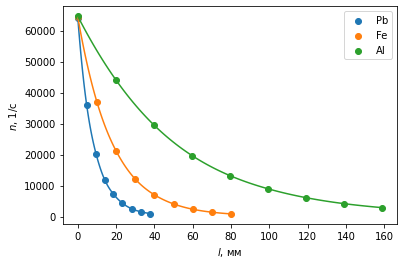

In [237]:
from scipy.interpolate import make_interp_spline

for elem in ('Pb', 'Fe', 'Al'):

    n = (data[elem]['N'] - NOISE) / data[elem]['T']
    l = data[elem]['L']

    x = np.linspace(l.min(), l.max(), 100)
    y = make_interp_spline(l, n)(x)

    #plt.errorbar(l, n, label=elem, yerr=10, fmt='.')  
    plt.scatter(l, n, label=elem) 
    plt.plot(x, y)


plt.xlabel(r"$l$, мм")
plt.ylabel(r"$n$, 1/c")
plt.legend()

plt.savefig('gen/fig-nl.pdf')

\mu_{\text{Pb}} = 1.11\pm0.01 \;\;\text{см}^{-1}
\mu_{\text{Fe}} = 0.54\pm0.00 \;\;\text{см}^{-1}
\mu_{\text{Al}} = 0.20\pm0.00 \;\;\text{см}^{-1}


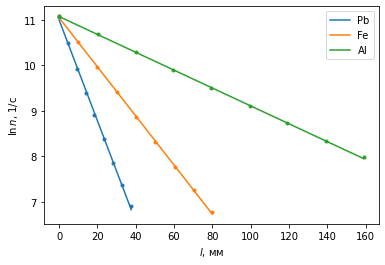

In [243]:
mus = {}

elem = 'Pb'

for elem in ('Pb', 'Fe', 'Al'):

    n = np.log((data[elem]['N'] - NOISE) / data[elem]['T'])
    l = data[elem]['L']

    x, y, equ = mipt.plot(l, n, label=elem) 

    mnk = mipt.mnk(x, y)
    a = mnk.data['a'][0]
    da = mnk.data['da'][0]
        
    mus[elem] = -a*10
    export('gen/eq-{}.tex'.format(elem), '\\mu_{{\\text{{{}}}}} = {:.2f}\pm{:.2f} \\;\\;\\text{{см}}^{{-1}}'.format(elem, -a*10, da*10))

    
plt.xlabel(r"$l$, мм")
plt.ylabel(r"$\ln{n}$, 1/c")
plt.legend()

plt.savefig('gen/fig-lnnl.pdf')

## Коэффициенты $\rho'$

In [244]:
rho = {
    'Pb' : 13.35, 
    'Fe' : 7.87, 
    'Al' : 2.7,
}

In [250]:
for elem in ('Pb', 'Fe', 'Al'):
    
    print( mus[elem] / rho[elem] )
    

0.0828881169274968
0.06854479060081928
0.07270960337984463
